# Work for 2nd Project Update

First we'll take the relevant methods from preview_request so we can get the information of any song

In [2]:
from preview_request import preview_request, convert_to_wav

We'll need to work with arrays and audio

In [3]:
import numpy as np
import pandas as pd
import librosa

For some *mild* color manipulation

In [4]:
import colorsys

For animation

In [5]:
from manim import *

### Example of Manim in Jupyter

In [6]:
class RemoveObjectExample(Scene):
    def construct(self):
        text = Text("Alice and Bob").scale(3)
        self.add(text)
        self.wait(3)
        self.remove(text)
        
        # Display the circle
        circle = Circle()
        self.play(Create(circle))
        self.wait(1)
        self.remove(circle)

%manim -ql -v WARNING RemoveObjectExample

Manim Community v0.18.1

# First Method: Changing Backgrounds

We'll need to convert from rgb to hex codes:

In [7]:
def rgb_to_hex(rgb):
    '''
    param: tuple of rgb coded colors
    returns: hex string
    '''
    if type(rgb) != tuple:
        rgb = tuple(rgb)
    return '%02x%02x%02x' % rgb

Normalize values between 0-255 for rgb codes

In [8]:
def norm_for_color(array):
    '''
    param: np array
    returns: np array normalized between 0-255
    '''
    min_val = np.min(array)
    max_val = np.max(array)
    
    normalized_array = (array - min_val) / (max_val - min_val) * 255
    return normalized_array

Here's the driving manim code:

In [9]:
class colorChanger(Scene):
    def construct(self):
        # audio_file_name = preview_request() #for terminal
        audio_file_name = "GMGM_short.wav"
        y, sr = librosa.load(audio_file_name)

        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)
        
        song_time = librosa.get_duration(y=y, sr=sr)
        
        #Fix last couple seconds
        if beat_times[-1] < song_time:
            beat_times = np.concatenate((beat_times, np.linspace(beat_times[-1], song_time-0.01, 4)))

        percent_through_song = beat_times/song_time


        num_to_take_from_y_1 = ((percent_through_song-0.02)*y.size).astype(int)
        num_to_take_from_y_2 = ((percent_through_song-0.01)*y.size).astype(int)
        num_to_take_from_y_3 = ((percent_through_song+0.00)*y.size).astype(int)

        # Normalize the audio values to generate RGB color channels
        r = norm_for_color(y[num_to_take_from_y_1]).astype(int)
        b = norm_for_color(y[num_to_take_from_y_2]).astype(int)
        g = norm_for_color(y[num_to_take_from_y_3]).astype(int)

        zip_obj = zip(r,b,g)
        color_list = list(zip_obj)

        vectorized_function = np.vectorize(rgb_to_hex, signature='(n)->()')
        list_of_colors = vectorized_function(np.array(color_list))

        cues = np.diff(beat_times)
        
        self.add_sound(audio_file_name)

        for i in range(len(cues)):
            text = Text(f"{beat_times[i]:.2f}", font_size=144)
            self.add(text)  
            self.wait(cues[i])

            self.camera.background_color = "#"+list_of_colors[i]
            self.remove(text)
            
%manim -ql -v WARNING colorChanger

Manim Community v0.18.1

C:\Users\ives7\AppData\Local\Temp\ipykernel_19380\3584584154.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_name)
C:\Users\ives7\anaconda3\envs\PIC16B-25W\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'GMGM_short.wav'

# Second Method:

We're going to use this song for the following example:

In [95]:
audio_file_name = "GMGM_short.wav"
y, sr = librosa.load("GMGM_short.wav")

tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

To make the visualizations more "human" I'll think about the colors in HSV and since manim will accept hex values, we want a way to convert between the two:

In [96]:
def hsv_to_hex(hsv):
    h, s, v = hsv
    #Convert 
    h = h/360
    s = s/100
    v = v/100
    
    # Convert HSV to RGB using colorsys
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    
    # Convert RGB to HEX
    hex_color = '{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255))
    
    return hex_color

We'll want a way to normalize a numpy array between 0-n.

In [97]:
def norm_to_n(array, n=1):
    '''
    param: np array
    returns: np array normalized between 0-n
    '''
    min_val = np.min(array)
    max_val = np.max(array)
    
    normalized_array = (array - min_val) / (max_val - min_val) * n
    return normalized_array

## Step 1: Get *Pitch* for Brightness

In [98]:
# Function to extract pitch at specific timestamps
def extract_max_pitches(y, sr, beat_times, duration=0.1):
    pitches = []
    for time in beat_times:
        # Extract a segment of audio around each timestamp
        start_sample = int(time * sr)
        end_sample = int((time + duration) * sr)
        segment = y[start_sample:end_sample]

        # Get pitch
        pitches_segment, magnitudes = librosa.core.piptrack(y=segment, sr=sr)
        
        # Get the maximum pitch from the frame with the highest magnitude
        max_pitch = np.max(pitches_segment)
        if max_pitch > 0:
            pitches.append(max_pitch)
        else:
            pitches.append(0)  # No pitch detected
    
    return np.array(pitches)

Let's test out the function:

In [99]:
pitches = extract_max_pitches(y,sr,beat_times)

Notice `beat_times` and `pitches` have the same size:

In [100]:
beat_times.shape, pitches.shape

((20,), (20,))

Here's what the `pitches` array looks like.

In [101]:
pitches

array([3963.3684, 1911.0146, 1444.118 , 1724.6978, 3501.682 , 3144.96  ,
       3505.9402, 2945.83  , 2075.037 , 3667.432 , 3951.5813, 3070.7861,
        341.7259, 3996.9146, 2952.812 , 3629.7053, 3993.6128, 2940.2007,
       1134.7648, 3683.2927], dtype=float32)

And what normalizing will do:

In [102]:
B = norm_to_n(pitches, 100)
B.astype(int) #for viewing purposes

array([ 99,  42,  30,  37,  86,  76,  86,  71,  47,  90,  98,  74,   0,
       100,  71,  89,  99,  71,  21,  91])

## Step 2: Get Volume for Saturation

In [103]:
# Function to extract pitch at specific timestamps
def extract_max_volume(y, sr, beat_times, duration=0.1):
    volumes = []
    for time in beat_times:
        # Extract a segment of audio around each timestamp
        start_sample = int(time * sr)
        end_sample = int((time + duration) * sr)
        segment = y[start_sample:end_sample]

        # Get volume
        rms = librosa.feature.rms(y=segment)
        rms_db = librosa.amplitude_to_db(rms)
        
        # Get the maximum volume
        max_vol = np.max(rms_db)
        volumes.append(max_vol)
    
    return np.array(volumes)

In [104]:
volumes = extract_max_volume(y, sr, beat_times)
volumes

array([-24.208582, -15.5371  , -13.817259, -12.540924, -14.107727,
       -14.334766, -12.101099, -14.683283, -13.998818, -13.993154,
       -14.964004, -14.231014, -16.18017 , -13.112265, -17.016418,
       -15.444347, -12.484895, -15.126887, -15.156284, -14.447465],
      dtype=float32)

In [105]:
S = norm_to_n(volumes, 100)
S.astype(int) #for viewing purposes

array([  0,  71,  85,  96,  83,  81, 100,  78,  84,  84,  76,  82,  66,
        91,  59,  72,  96,  75,  74,  80])

## Step 3: Get Note (within Octave) for Hue

In [106]:
notes = librosa.hz_to_note(pitches, octave=False)
notes

array(['B', 'A♯', 'F♯', 'A', 'A', 'G', 'A', 'F♯', 'C', 'A♯', 'B', 'G',
       'F', 'B', 'F♯', 'A♯', 'B', 'F♯', 'C♯', 'A♯'], dtype='<U2')

In [107]:
note_map = {
    'C':1,
    'C♯':1.5,
    'D':2,
    'D♯':2.5,
    'E':3,
    'F':4,
    'F♯':4.5,
    'G':5,
    'G♯':5.5,
    'A':6,
    'A♯':5.5,
    'B':7
}

In [108]:
note_vals = [note_map[note] for note in notes]
np.array(note_vals) #made nparray for viewing purposes

array([7. , 5.5, 4.5, 6. , 6. , 5. , 6. , 4.5, 1. , 5.5, 7. , 5. , 4. ,
       7. , 4.5, 5.5, 7. , 4.5, 1.5, 5.5])

In [109]:
H = norm_to_n(note_vals,360)
H.astype(int)  #for viewing purposes

array([360, 270, 210, 300, 300, 240, 300, 210,   0, 270, 360, 240, 180,
       360, 210, 270, 360, 210,  30, 270])

## Step 4: Separate and Detect Different Sounds 

In [110]:
#harmonic percussive separation 
y_harmonic, y_percussive = librosa.effects.hpss(y)
y_harmonic

array([-0.04104443, -0.07785336, -0.08979892, ..., -0.19598143,
       -0.17894839, -0.10664387], dtype=float32)

In [111]:
y_percussive

array([-0.0187327 , -0.03666369, -0.04058429, ..., -0.02103764,
       -0.01232541,  0.01931584], dtype=float32)

We can detect local note onset events with librosa in our percussive array

In [112]:
# onset detection
o_env = librosa.onset.onset_strength(y=y_percussive, sr=sr)


# onset strength per unit
onset_frames = librosa.onset.onset_detect(y=y_percussive, sr=sr, units="time")
onset_frames

array([ 0.06965986,  0.27863946,  0.60371882,  1.09133787,  1.25387755,
        2.06657596,  2.22911565,  2.73995465,  2.90249433,  3.0185941 ,
        3.13469388,  3.25079365,  3.36689342,  3.4829932 ,  3.69197279,
        3.97061224,  4.17959184,  4.43501134,  4.71365079,  4.96907029,
        5.15482993,  5.68888889,  6.01396825,  6.17650794,  6.5015873 ,
        6.68734694,  7.17496599,  7.59292517,  8.05732426,  8.17342404,
        8.68426304,  8.93968254,  9.17188209,  9.42730159,  9.68272109,
        9.91492063, 10.12390023, 10.65795918, 11.14557823, 11.42421769,
       11.63319728, 12.14403628, 12.58521542, 12.88707483, 13.11927438,
       13.37469388, 13.4675737 ])

From the documentation, here is an example of how we can visualize onsets!

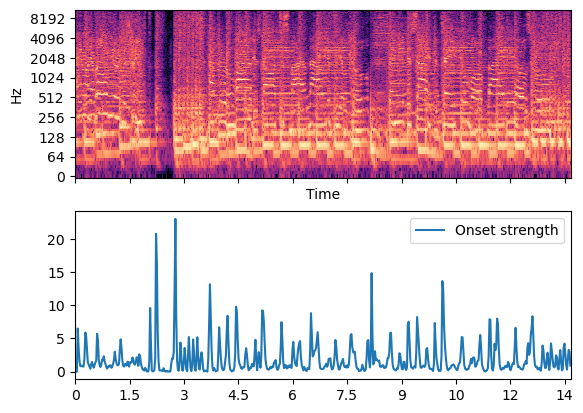

In [144]:
import matplotlib.pyplot as plt
times = librosa.times_like(o_env, sr=sr)

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log', ax=ax[0], sr=sr)

ax[1].plot(times, o_env, label='Onset strength')
ax[1].legend()

We can also detect the spectral centroids per unit to maybe do something like exapnd the text during high frequency, brighter sounds 

In [145]:
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
norm_centroid = (spectral_centroid - spectral_centroid.min()) / (spectral_centroid.max() - spectral_centroid.min())

## Zip and Colorize!

As before, we'll zip to make the color channels and colorize!

In [114]:
zip_obj = zip(H,S,B)
color_list = list(zip_obj)

Let's look at the first ~10 values

In [115]:
color_list[:10] 

[(360.0, 0.0, 99.08223),
 (270.0, 71.62085, 42.93318),
 (210.0, 85.82563, 30.159649),
 (300.0, 96.36733, 37.835854),
 (300.0, 83.426544, 86.45125),
 (240.0, 81.551346, 76.69191),
 (300.0, 100.0, 86.56774),
 (210.0, 78.67283, 71.24404),
 (0.0, 84.326065, 47.420567),
 (270.0, 84.37285, 90.98589)]

Again we'll vectorize the function and apply:

In [116]:
vectorized_function = np.vectorize(hsv_to_hex, signature='(n)->()')
list_of_colors = vectorized_function(np.array(color_list))
list_of_colors

array(['fcfcfc', '461f6d', '0a2b4c', '600360', 'dc24dc', '2424c3',
       'dc00dc', '266eb5', '781212', '8624e8', 'fb3b3b', '2121be',
       '000000', 'ff1515', '4980b6', '923fe5', 'fe0808', '2d71b5',
       '37220d', '8b2de9'], dtype='<U6')

## Play!

In [143]:
class hsvAnim(Scene):
    def construct(self):
        # audio_file_name = preview_request()
        # y, sr = librosa.load(audio_file_name)
        audio_file_name = "GMGM_30.wav"
        y, sr = librosa.load("GMGM_30.wav")
        
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)

        song_time = librosa.get_duration(y=y, sr=sr)

        #prevent last 5 sec from being constant
        if beat_times[-1] < song_time:
            beat_times = np.concatenate((beat_times, np.linspace(beat_times[-1], song_time-0.01, 4)))

        # harmonic-percussive separation
        y_harmonic, y_percussive = librosa.effects.hpss(y)

        # onset detection 
        # onset_env = librosa.onset.onset_strength(y=y_percussive, sr=sr)
        # onset_times = librosa.onset.onset_detect(y=y_percussive, sr=sr, units="time")

        # spectral centroid for brightness 
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        norm_centroid = (spectral_centroid - spectral_centroid.min()) / (spectral_centroid.max() - spectral_centroid.min())

        # Extract Pitch and Volume
        pitches = extract_max_pitches(y, sr, beat_times)
        volumes = extract_max_volume(y, sr, beat_times)
        
        note_map = {
            'C':1,'C♯':1.5,
            'D':2,'D♯':2.5,
            'E':3,
            'F':4,'F♯':4.5,
            'G':5,'G♯':5.5,
            'A':6,'A♯':5.5,
            'B':7
        }
        
        pitches = extract_max_pitches(y, sr, beat_times)
        volumes = extract_max_volume(y, sr, beat_times)

        notes = librosa.hz_to_note(pitches, octave=False)
        note_vals = [note_map[note] for note in notes]

        H = norm_to_n(note_vals,360)
        S = norm_to_n(volumes, 100)
        B = norm_to_n(pitches, 100)


        zip_obj = zip(H,S,B)
        color_list = list(zip_obj)

        vectorized_function = np.vectorize(hsv_to_hex, signature='(n)->()')
        list_of_colors = vectorized_function(np.array(color_list))

        cues = np.diff(beat_times)
        
        self.add_sound(audio_file_name)


        for i in range(len(cues)):
            text = Text(f"{beat_times[i]:.2f}", font_size=144)
            # text size expands during high frequency sounds 
            text.scale(1 + norm_centroid[i] * 6)
            
            self.add(text)  
            self.wait(cues[i])
            self.camera.background_color = "#"+list_of_colors[i]
            self.remove(text)
            
        self.wait(3)
    
%manim -ql -v WARNING hsvAnim

Manim Community v0.18.1

/opt/anaconda3/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=221
  warnings.warn(


# Some Extra Animations:

In [52]:
import numpy as np

class RosePattern(VMobject):
    def __init__(self, radius: float = 2, k: float = 3, theta_range=TAU, **kwargs):
        super().__init__(**kwargs)
        self.radius = radius
        self.k = k

        step_size = 0.1
        theta = np.arange(0, theta_range + step_size, step_size)

        points = [
            [
                radius * np.cos(k * t) * np.cos(t),
                radius * np.cos(k * t) * np.sin(t),
                0
            ] for t in theta
        ]

        self.set_points_smoothly(points)
        
class ShowingRosePattern(Scene):
    def construct(self):
        self.camera.background_color = '#7fbf26'
        rose = RosePattern(k=8, color=RED, stroke_width=15)

        self.play(Create(rose), run_time=5)
        self.wait()
        
%manim -ql -v WARNING ShowingRosePattern

Manim Community v0.18.1

# Other Project updates

Example of using onset detection for color change instead of beats:
- issues with matching up onset times with color list and cues but first 5 seconds works (with little visual appeal)

In [1]:
class hsvAnim(Scene):
    def construct(self):
        # audio_file_name = preview_request()
        # y, sr = librosa.load(audio_file_name)
        audio_file_name = "GMGM_30.wav"
        y, sr = librosa.load("GMGM_30.wav")
        
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        # beat_times = librosa.frames_to_time(beat_frames, sr=sr)

        song_time = librosa.get_duration(y=y, sr=sr)

        #prevent last 5 sec from being constant
        # if beat_times[-1] < song_time:
        #     beat_times = np.concatenate((beat_times, np.linspace(beat_times[-1], song_time-0.01, 4)))

        # harmonic-percussive separation
        y_harmonic, y_percussive = librosa.effects.hpss(y)

        # onset detection 
        onset_env = librosa.onset.onset_strength(y=y_percussive, sr=sr)
        onset_times = librosa.onset.onset_detect(y=y_percussive, sr=sr, units="time")

        # spectral centroid for brightness 
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        norm_centroid = (spectral_centroid - spectral_centroid.min()) / (spectral_centroid.max() - spectral_centroid.min())

        # Extract Pitch and Volume
        pitches = extract_max_pitches(y, sr, beat_times)
        volumes = extract_max_volume(y, sr, beat_times)
        
        note_map = {
            'C':1,'C♯':1.5,
            'D':2,'D♯':2.5,
            'E':3,
            'F':4,'F♯':4.5,
            'G':5,'G♯':5.5,
            'A':6,'A♯':5.5,
            'B':7
        }


        pitches = extract_max_pitches(y, sr, beat_times)
        volumes = extract_max_volume(y, sr, beat_times)

        notes = librosa.hz_to_note(pitches, octave=False)
        note_vals = [note_map[note] for note in notes]

        H = norm_to_n(note_vals,360)
        S = norm_to_n(volumes, 100)
        B = norm_to_n(pitches, 100)


        zip_obj = zip(H,S,B)
        color_list = list(zip_obj)

        vectorized_function = np.vectorize(hsv_to_hex, signature='(n)->()')
        list_of_colors = vectorized_function(np.array(color_list))
    
        self.add_sound(audio_file_name)

        # trying to add color change based on onsets
        num_onsets = len(onset_times)
        num_colors = len(list_of_colors)

        if num_onsets > num_colors:
            onset_times = onset_times[:num_colors]  # Clip onset_times to match number of colors
        elif num_onsets < num_colors:
            list_of_colors = list_of_colors[:num_onsets]  # Clip list_of_colors to match onset_times

        cues = np.diff(onset_times)
        
        for i in range(min(len(cues), len(list_of_colors))):
            text = Text(f"{onset_times[i]:.2f}", font_size=144)
            text.scale(1 + norm_centroid[i] * 6)

            # wait_time = cues[i] if cues[i] > 0.1 else 0.1 
            
            self.add(text)
            self.wait(cues[i]) 
            self.camera.background_color = "#"+list_of_colors[i]  
            self.remove(text)  

        # for i in range(len(cues)):
        #     text = Text(f"{beat_times[i]:.2f}", font_size=144)
        #     # text size expands during high frequency sounds 
        #     text.scale(1 + norm_centroid[i] * 6)
            

        #     self.add(text)  
        #     self.wait(cues[i])
        #     self.camera.background_color = "#"+list_of_colors[i]
        #     self.remove(text)

        duration = sum(cues) + 3
        self.wait(duration)
    
%manim -ql -v WARNING hsvAnim

NameError: name 'Scene' is not defined